# Análisis multivariable de consumo energético del vehículo eléctrico

### Alumno: Daniel Lugo Laguna

## 1. Introducción

En este estudio se analizan los datos de un conjunto de trayectos realizados por 20 vehículos eléctricos del mismo modelo (Mitsubishi iMiEV, Modelo 2010) en distintos puntos de Australia, con el objetivo de estudiar el impacto de distintas características y factores externos del trayecto sobre el consumo energético de la batería del mismo. A partir del modelo construido, se extrapolan los resultados al estado actual del sector en España y se presentan las conclusiones correspondientes.

## 2. Descripción del Dataset

El dataset utilizado en este trabajo está publicado en el repositorio de datos abiertos del gobierno de Australia. Se puede encontrar en el siguiente enlace: https://data.gov.au/data/dataset/smart-grid-smart-city-electric-vehicle-trial-data 

Este conjunto de datos muestra información de rutas (tanto de particulares como empresas) realizadas por 20 vehículos eléctricos modelo Mitsubishi iMiEV 2010, como parte del proyecto Smart Grid Smart City (SGSC). **El principal aliciente de este dataset es que, además de características específicas del trayecto como la distancia total recorrida, número de pasajeros o la velocidad promedio, también permite incluir en el análisis el uso de sistemas auxiliares del vehículo** (aire acondicionado, calefacción, faros del vehículo).

Se realiza en primer lugar una inicialización de las librerías necesarias para el análisis

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from numpy import mean
from numpy import std

import sklearn
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline


from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.callbacks import EarlyStopping

## 3. Análisis exploratorio de las variables y preparación del Dataset

### 3.1 Carga del Dataset inicial

Se procede a cargar el fichero de trabajo. El mismo está en formato csv con separador el caracter separador coma.

In [4]:
import pandas as pd
df_EV_raw = pd.read_csv(r'C:\Users\Usuario\Desktop\Master UOC\Master ciencia de datos\TFM\sgsc-ev-electric-vehicles-data.csv',
                        delimiter=",")

### 3.2 Estudio de variables para el análisis

Se comprobarán en primer lugar las dimensiones del Dataset.

In [5]:
shape = df_EV_raw.shape
print('El numero de filas del dataset es: %d' % (shape[0]))
print('El numero de columnas del dataset es: %d' % (shape[1]))

El numero de filas del dataset es: 26155
El numero de columnas del dataset es: 50


Se tiene por tanto, a priori, una tabla con 26.155 trayectos y 50 variables asociadas. Se visualiza a continuación una muestra de 5 trayectos del conjunto.

In [6]:
df_EV_raw.head()

,TEL_TRIPSTART,TEL_STARTODO,TEL_TRIPEND,TEL_ENDODO,TEL_SOC_START,TEL_SOC_END,TEL_AVG_VELOCITY,AC_ON_DURATION,AC_ON_PCT,HEADLAMP_ON_DURATION,...,TRIP_DISTANCE,DISTANCE_GPS,TEL_DISTANCE,CALC_DISTANCE,NO_PASSENGERS,ACCESSORIES,LOG_AVG_VELOCITY,GPS_AVG_VELOCITY,START_ALTITUDE,END_ALTITUDE
0,01:51.8,9681.0,04:50.8,9682.0,86.0,86.0,20.00,0.00,0.0,2.98,...,NaN,NaN,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,57:29.2,17784.0,12:46.2,17785.0,79.0,77.0,4.00,15.28,NaN,0.00,...,NaN,NaN,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN
2,54:51.9,9776.0,04:31.9,9782.0,78.0,74.0,36.00,0.00,0.0,9.67,...,5.0,NaN,6.0,6,1.0,[NONE],37.50,0.0,NaN,NaN
3,01:26.8,12362.0,34:27.9,12393.0,97.0,69.0,56.36,0.00,0.0,0.00,...,31.0,NaN,31.0,31,1.0,[NONE],66.43,0.0,NaN,NaN
4,07:59.3,25665.0,44:42.4,25699.0,103.0,78.0,55.14,0.00,0.0,0.00,...,33.0,NaN,34.0,34,1.0,[NONE],55.00,0.0,NaN,NaN


Dado el alto número de variables que contiene el Dataset, se realizará en primer lugar una segregación de aquellas que pueden resultar a priori relevantes para la estimación del vehículo, usando como apoyo el diccionario de variables proporcionado como complemento en el repositorio original del Gobierno Australiano (https://data.gov.au/data/dataset/smart-grid-smart-city-electric-vehicle-trial-data/resource/b8adbdda-b4f2-4f1b-895d-f585477200af).

Se comentarán por tanto cada una de las variables, atendiendo a la tipología de las mismas.

#### 3.2.1 Variables espaciales y temporales del trayecto

Se muestra un subconjunto del dataset original con las variables de tipo **fecha**:

In [7]:
df_EV_raw.iloc[:, [0,2,27,29,30,31,35]].head()

,TEL_TRIPSTART,TEL_TRIPEND,CALENDAR_KEY,RECSTARTDATE,RECENDDATE,START_DATE,END_DATE
0,01:51.8,04:50.8,270742,01:51.8,04:50.8,NaN,NaN
1,57:29.2,12:46.2,270747,57:29.2,12:46.2,NaN,NaN
2,54:51.9,04:31.9,270747,54:53.0,02:44.0,54:53.0,02:44.0
3,01:26.8,34:27.9,270748,02:06.0,30:26.0,02:06.0,30:26.0
4,07:59.3,44:42.4,270748,07:46.0,43:18.0,07:46.0,43:18.0


Se revisan en primer lugar las variables de fecha de inicio y fin del trayecto. Esta información no viene asociada a un día concreto, ya que la información está anonimizada previamente en el Dataset. **Dado que se posee la longitud del trayecto en kilómetros, así como la velocidad promedio del mismo, todos estos campos se excluirán del análisis**. Se ha tomado esta decisión dado que las referencias temporales de estas fechas no están claras (la referencia de inicio del trayecto, a veces es superior a la finalización). Además no aportan información adicional, pudiendo añadir en su lugar los campos anteriormente mencionados, sin perder por ello calidad el análisis.

A continuación se muestran las variables de distancia, **localización y velocidad de los vehículos**:

In [8]:
df_EV_raw.iloc[:, [6,46,47,48,49]].head()

,TEL_AVG_VELOCITY,LOG_AVG_VELOCITY,GPS_AVG_VELOCITY,START_ALTITUDE,END_ALTITUDE
0,20.00,NaN,NaN,NaN,NaN
1,4.00,NaN,NaN,NaN,NaN
2,36.00,37.50,0.0,NaN,NaN
3,56.36,66.43,0.0,NaN,NaN
4,55.14,55.00,0.0,NaN,NaN


In [9]:
df_EV_raw.iloc[:, [1,3,32,36,37,40,41,42,43]].head()

,TEL_STARTODO,TEL_ENDODO,START_ODO_ACTUAL,END_ODO_EST,END_ODO_ACTUAL,TRIP_DISTANCE,DISTANCE_GPS,TEL_DISTANCE,CALC_DISTANCE
0,9681.0,9682.0,NaN,NaN,NaN,NaN,NaN,1.0,1
1,17784.0,17785.0,NaN,NaN,NaN,NaN,NaN,1.0,1
2,9776.0,9782.0,9776.0,9781.0,9782.0,5.0,NaN,6.0,6
3,12362.0,12393.0,12362.0,12393.0,12393.0,31.0,NaN,31.0,31
4,25665.0,25699.0,25665.0,25698.0,25699.0,33.0,NaN,34.0,34


- **Velocidad y altitud**: TEL_AVG_VELOCITY Y LOG_AVG_VELOCITY representan ambas la velocidad promedio del trayecto pero medidas de distinta forma. Estas variables pueden ser interesantes para el análisis, pero antes será necesario identificar si las medidas son congruentes entre sí y decidir cuál de ellas formará parte del dataset final. La variable GPS_AVG_VELOCITY aparece a 0 o con valor perdido en todos los casos, se excluirá la misma por tanto del estudio. Las variables de altitud inicial y final del trayecto contienen también valores perdidos en todos los registros. Serán por tanto excluídos del análisis.


- **Distancia**: En el Dataset aparecen diferentes variables para medir el kilometraje inicial y final, tomadas con distintos medidores. Uno de los campos TRIP_DISTANCE, de acuerdo al diccionario, contiene la distancia total del trayecto tomada de la fuente disponible más fiable (DISTANCE_GPS aperece como valor perdido en todos los registros.). Sin embargo como se verá más adelante, existen valores perdidos. Se mantienen por tanto las mediciones de telemetría TEL_STARTODO y TEL_ENDODO para completar valores perdidos de distancia total. Se excluyen las variables de kilometraje duplicadas (START_ODO_ACTUAL, END_ODO_EST, END_ODO_ACTUAL), así como las distancias calculadas excepto TRIP_DISTANCE (TEL_DISTANCE,CALC_DISTANCE)

#### 3.2.2 Variables de tipología e identificación de trayecto y vehículo

Se muestra a continuación un subconjunto del dataset original con las variables relacionadas con la **tipología e identificación de trayecto y vehículo**:

In [10]:
df_EV_raw.iloc[:, [11,12,26,28]].head()

,TRIPSTART_LOCN,TRIPEND_LOCN,TRIP_ID,VEHICLE_ID
0,Other,Other,15809,9
1,Other,Other,18751,10
2,Home,Other,8529,7
3,Home,Work,12108,8
4,Home,Work,39702,17


Las variables de esta tipología permiten, por un lado, obtener más información sobre el trayecto realizado y por otro, identificar únivocamente los mismos a través de un identificador tanto del coche como del propio trayecto. El campo TRIP_ID se mantendrá a efectos de detección de duplicados. El campo VEHICLE_ID se mantendrá con el objetivo de detectar posibles consumos anómalos de energía para un vehículo concreto durante las pruebas, lo cual podría sesgar los datos durante el proceso de estimación del consumo energético.

#### 3.2.3 Sistemas auxiliares, ocupación del vehículo y temperatura exterior

Otro aspecto importante consisten en el uso de sistemas auxiliares del vehículo durante el trayecto, así como la ocupación del mismo. Se muestran a continuación las variables relacionadas con esta tipología.

In [11]:
df_EV_raw.iloc[:, [7,8,9,10,13,44,45]].head()

,AC_ON_DURATION,AC_ON_PCT,HEADLAMP_ON_DURATION,HEADLAMP_ON_PCT,TEMPERATURE,NO_PASSENGERS,ACCESSORIES
0,0.00,0.0,2.98,NaN,NaN,NaN,NaN
1,15.28,NaN,0.00,0.0,NaN,NaN,NaN
2,0.00,0.0,9.67,NaN,NaN,1.0,[NONE]
3,0.00,0.0,0.00,0.0,NaN,1.0,[NONE]
4,0.00,0.0,0.00,0.0,NaN,1.0,[NONE]


En el dataset se puede consultar información sobre tiempo funcionando de las luces del vehículo (HEADLAMP_ON_DURATION) y aire acondicionado (AC_ON_DURATION). Existen dos variables complementarias que en teoría mostrarían la información en porcentaje del trayecto, pero lamentablemente aparecen como valores perdidos (AC_ON_PCT y HEADLAMP_ON_PCT). NO_PASSENGERS muestra el número de pasajeros del vehículo durante su uso, la cual se usará como predictor. La variable ACCESORIES indica si durante el trayecto se hace uso de calefacción, aire acondicionado y luces del vehículo. Esta información no aporta nada nuevo a priori, ya que mediante los campos anteriores se tiene el tiempo de consumo de estos accesorios.

La variable TEMPERATURE, que mostraría la temperatura exterior, lamentablemente aparece como un valor perdido en todos los casos.

#### 3.2.4 Información de carga de la batería

In [12]:
df_EV_raw.iloc[:,14:25].head()

,CHARGE_TYPE,CONNECT_START,CHARGE_START,CONNECT_END,CHARGE_END,CHARGE_AMOUNT,FULLCHARGEFLAG,CHARGING_OCCURRENCES,UNACCOUNTED_KM,FULLCHARGE_KMSPAN,FULLCHARGE_EFFICIENCY
0,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0.0,9.0,0.0
1,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.0,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.0,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.0,NaN,NaN


In [13]:
df_EV_raw.iloc[:, [38,39]].head()

,END_BAT_EST,END_BAT_ACTUAL
0,NaN,NaN
1,NaN,NaN
2,13.0,12.0
3,11.0,11.0
4,11.0,13.0


Existe un buen número de campos que muestran datos sobre la recarga del vehículo, incluyendo tiempos de inicio y fin de carga, indicador de carga completa, eficiencia, etc. Esta información no resulta relevante para este paso del estudio, ya que se pretende medir el consumo energético del vehículo para un determinado trayecto y bajo determinadas condiciones. En consecuencia, las variables de esta sección serán eliminadas para el análisis posterior.

#### 3.2.5 Variable Objetivo - estado de carga de la batería

In [14]:
df_EV_raw.iloc[:, [4,5]].head()

,TEL_SOC_START,TEL_SOC_END
0,86.0,86.0
1,79.0,77.0
2,78.0,74.0
3,97.0,69.0
4,103.0,78.0


Como ya se ha indicado anteriormente, en este estudio se presente medir el consumo energético del vehículo en un conjunto de trayectos determinado. Las variables TEL_SOC_START y TEL_SOC_END muestran el estado de carga al inicio y final del trayecto por parte del vehículo, medido en porcentaje. La diferencia de estos dos campos será la variable objetivo de este estudio.

### 3.3 Limpieza y enriquecimiento del Dataset

Una vez descritas las variables a utilizar, se comenzará la limpieza del dataset y el cálculo de la información adicional necesaria. 

##### Selección de variables

Comenzaremos filtrando el conjunto de datos únicamente por las variables candidatas seleccionadas en el punto anterior.

In [15]:
df_EV_filtered = df_EV_raw.iloc[:, [26,28,1,3,40,6,46,7,9,44,4,5]]

Las variables seleccionadas en este primer cribado son las siguientes:

In [16]:
for c in df_EV_filtered.columns:
    print(c)

TRIP_ID
VEHICLE_ID
TEL_STARTODO
TEL_ENDODO
TRIP_DISTANCE
TEL_AVG_VELOCITY
LOG_AVG_VELOCITY
AC_ON_DURATION
HEADLAMP_ON_DURATION
NO_PASSENGERS
TEL_SOC_START
TEL_SOC_END


##### Eliminación de valores perdidos

Esta tabla contiene muchos datos empíricos procedentes de telemetrías, por tanto es de esperar que existan valores perdidos en las variables. Se comprueba este aspecto a continuación.

In [17]:
df_EV_filtered.isnull().sum()

TRIP_ID                     0
VEHICLE_ID                  0
TEL_STARTODO             4553
TEL_ENDODO               4553
TRIP_DISTANCE            9954
TEL_AVG_VELOCITY         4553
LOG_AVG_VELOCITY         9817
AC_ON_DURATION           4553
HEADLAMP_ON_DURATION     4553
NO_PASSENGERS           13102
TEL_SOC_START            4553
TEL_SOC_END              4553
dtype: int64

Efectivamente el número de valores perdidos es considerable. Algunos de ellos es posible que puedan corregirse con estimaciones o combinación de campos. Sin embargo, aquellos que tengan las variables objetivos como valor perdido no pueden incluirse en el análisis. Estos registros quedan excluidos.

In [18]:
df_EV_filtered = df_EV_filtered.dropna(subset=df_EV_filtered.columns[[11]])

In [19]:
df_EV_filtered.isnull().sum()

TRIP_ID                     0
VEHICLE_ID                  0
TEL_STARTODO                0
TEL_ENDODO                  0
TRIP_DISTANCE            9954
TEL_AVG_VELOCITY            0
LOG_AVG_VELOCITY         9817
AC_ON_DURATION              0
HEADLAMP_ON_DURATION        0
NO_PASSENGERS           12090
TEL_SOC_START               0
TEL_SOC_END                 0
dtype: int64

Quedan tres importantes fuentes de valores perdidos: distancia del trayecto, velocidad media y número de pasajeros.

- **Distancia de trayecto:** La variable trip distance tiene un gran número de valores perdidos. Dado que tanto TEL_STARTODO como TEL_ENDODO están disponibles, se calculará la distancia total recorrida restando ambos valores, presciendo por tanto de TRIP_DISTANCE.
- **Velocidad promedio:** LOG_AVG_VELOCITY tiene alto número de valores perdidos, por lo que se usará TEL_AVG_VELOCITY como variable predictora y se eliminará el campo anterior.
- **Número de pasajeros:** A pesar de ser una variable candidata para tener relevancia en el análisis, el alto número de valores perdidos puede empeorar la calidad del mismo. Se realizará la estimación de consumo energético con y sin esta variable.

##### Filtrado de valores anómalos

In [20]:
print('Tras el filtrado previo, el numero de filas del dataset es: %d' % (df_EV_filtered.shape[0]))

Tras el filtrado previo, el numero de filas del dataset es: 21602


Para detectar valores anómalos en alguna de las variables, se estudian diferentes estadísticos de cada una de ellas: media,desviación estándar,percentiles y valores máximos y mínimos.

In [21]:
df_EV_filtered.describe()

,TRIP_ID,VEHICLE_ID,TEL_STARTODO,TEL_ENDODO,TRIP_DISTANCE,TEL_AVG_VELOCITY,LOG_AVG_VELOCITY,AC_ON_DURATION,HEADLAMP_ON_DURATION,NO_PASSENGERS,TEL_SOC_START,TEL_SOC_END
count,21602.000000,21602.000000,21602.000000,21602.000000,11648.000000,21602.000000,11785.000000,21602.000000,21602.000000,9512.000000,21602.000000,21602.000000
mean,30539.113091,14.321776,12809.174336,12821.914406,13.982658,29.899478,32.350770,6.783752,5.266042,1.446173,81.037080,64.619711
std,17892.185171,5.785378,6929.661127,6931.234368,13.490516,27.267432,15.142888,12.516848,11.684957,0.754508,242.980047,22.538538
min,1.000000,5.000000,256.000000,260.000000,1.000000,-1.000000,0.370000,0.000000,0.000000,1.000000,5.000000,-5.000000
25%,13823.250000,9.000000,7604.500000,7615.750000,5.000000,18.000000,22.500000,0.000000,0.000000,1.000000,65.000000,49.000000
50%,30848.500000,14.000000,11920.000000,11930.000000,9.000000,26.470000,30.000000,0.000000,0.000000,1.000000,83.000000,68.000000
75%,44869.750000,19.000000,17103.000000,17114.750000,19.000000,36.000000,40.000000,9.230000,4.027500,2.000000,97.000000,83.000000
max,61945.000000,24.000000,32920.000000,32922.000000,90.000000,840.000000,109.090000,241.070000,105.700000,4.000000,26853.000000,107.000000


Los únicos valores que resultan incongruentes en un primer análisis están relacionados con la variable TEL_AVG_VELOCITY. En el valor mínimo se aprecian telemetrías negativas (lo cual es imposible) así como valores de velocidad promedio muy por encima de los límites de cualquier autopista. Se decide eliminar los valores negativos directamente. Respecto a las velocidades elevadas, el límite máximo de velocidad más elevado en Australia se da en determinadas autopistas, siendo de 130 km/h. (Fuente: https://en.wikipedia.org/wiki/Speed_limits_in_Australia#Default_speed_limits_by_state_and_territory). El filtro se establecerá en 130 + un rango de tolerancia de 10 (140 km/h en total)

In [22]:

df_EV_filtered = df_EV_filtered[(df_EV_filtered['TEL_AVG_VELOCITY']>0) & (df_EV_filtered['TEL_AVG_VELOCITY']< 140)]


Revisando los estados de carga de la batería también se detectan valores anómalos. En este caso se observan valores de carga por emcima de 100 y por debajo de 0. Dependiendo de como se haya medido esta variable, es posible que el dato sea ligeramente superior a 100 o ligeramente inferior a 0 tras una carga o descarga completa, se asignará una tolerancia de un 3% tanto por encima de 100 como por debajo de 0. El resto de registros serán eliminados.

In [23]:
df_EV_filtered = df_EV_filtered[(df_EV_filtered['TEL_SOC_START']>=-3) & (df_EV_filtered['TEL_SOC_START']<= 103)]

In [24]:
df_EV_filtered = df_EV_filtered[(df_EV_filtered['TEL_SOC_END']>=-3) & (df_EV_filtered['TEL_SOC_END']<= 103)]

In [25]:
print('Tras la eliminación de outliers, el número total de registros es de : %d' % (df_EV_filtered.shape[0]))

Tras la eliminación de outliers, el número total de registros es de : 20523


In [26]:
df_EV_filtered.describe()

,TRIP_ID,VEHICLE_ID,TEL_STARTODO,TEL_ENDODO,TRIP_DISTANCE,TEL_AVG_VELOCITY,LOG_AVG_VELOCITY,AC_ON_DURATION,HEADLAMP_ON_DURATION,NO_PASSENGERS,TEL_SOC_START,TEL_SOC_END
count,20523.000000,20523.000000,20523.000000,20523.000000,11042.000000,20523.000000,11177.000000,20523.000000,20523.000000,9026.000000,20523.000000,20523.000000
mean,30674.892218,14.364323,12825.631340,12838.011109,13.584948,28.281964,31.936034,6.753018,5.243835,1.454465,77.696974,64.438971
std,17867.952875,5.779544,6847.071245,6848.566077,13.063433,14.078355,14.902453,12.393583,11.607389,0.760360,20.541285,21.628715
min,1.000000,5.000000,256.000000,260.000000,1.000000,0.360000,0.370000,0.000000,0.000000,1.000000,5.000000,0.000000
25%,14188.000000,9.000000,7690.500000,7701.000000,5.000000,18.000000,22.040000,0.000000,0.000000,1.000000,64.000000,49.000000
50%,31074.000000,14.000000,11926.000000,11935.000000,9.000000,26.250000,30.000000,0.000000,0.000000,1.000000,81.000000,67.000000
75%,44896.500000,19.000000,17062.000000,17068.500000,18.000000,35.290000,40.000000,9.250000,4.080000,2.000000,96.500000,82.000000
max,61945.000000,24.000000,32920.000000,32922.000000,90.000000,135.000000,109.090000,241.070000,105.700000,4.000000,103.000000,102.000000


El resto de valores en los campos son, como mínimo, congruentes.

##### Cálculo de variables adicionales

In [27]:
#Calculo de nueva variable de distancia total.
df_EV_filtered["TOTAL_TRIP_DISTANCE"] = (df_EV_filtered["TEL_ENDODO"] - df_EV_filtered["TEL_STARTODO"])

#Calculo de nueva variable de consumo energético total
df_EV_filtered["TOTAL_ENERGY_CONSUMPTION"] = (df_EV_filtered["TEL_SOC_START"] - df_EV_filtered["TEL_SOC_END"])

In [28]:
#Se eliminan trayectos inferiores a 2 km para evitar desvirtuar los datos
df_EV_filtered = df_EV_filtered[(df_EV_filtered['TOTAL_TRIP_DISTANCE']>2)]

In [29]:
df_EV_filtered.head()

,TRIP_ID,VEHICLE_ID,TEL_STARTODO,TEL_ENDODO,TRIP_DISTANCE,TEL_AVG_VELOCITY,LOG_AVG_VELOCITY,AC_ON_DURATION,HEADLAMP_ON_DURATION,NO_PASSENGERS,TEL_SOC_START,TEL_SOC_END,TOTAL_TRIP_DISTANCE,TOTAL_ENERGY_CONSUMPTION
2,8529,7,9776.0,9782.0,5.0,36.00,37.50,0.00,9.67,1.0,78.0,74.0,6.0,4.0
3,12108,8,12362.0,12393.0,31.0,56.36,66.43,0.00,0.00,1.0,97.0,69.0,31.0,28.0
4,39702,17,25665.0,25699.0,33.0,55.14,55.00,0.00,0.00,1.0,103.0,78.0,34.0,25.0
5,23967,12,14008.0,14025.0,16.0,39.23,38.40,23.32,0.00,1.0,101.0,86.0,17.0,15.0
6,61141,24,19743.0,19766.0,NaN,30.00,NaN,0.00,0.00,NaN,102.0,75.0,23.0,27.0


In [30]:
df_EV_filtered = df_EV_filtered.iloc[:, [0,1,5,7,8,9,12,13]]

In [31]:
df_EV_filtered.describe()

,TRIP_ID,VEHICLE_ID,TEL_AVG_VELOCITY,AC_ON_DURATION,HEADLAMP_ON_DURATION,NO_PASSENGERS,TOTAL_TRIP_DISTANCE,TOTAL_ENERGY_CONSUMPTION
count,16935.000000,16935.000000,16935.000000,16935.000000,16935.000000,8345.000000,16935.000000,16935.000000
mean,30235.207972,14.214999,30.967474,7.737616,6.130331,1.436669,14.686094,15.614762
std,17783.432365,5.756322,13.350364,13.329386,12.544361,0.747381,12.704180,13.817388
min,2.000000,5.000000,0.360000,0.000000,0.000000,1.000000,3.000000,0.000000
25%,13843.000000,9.000000,22.110000,0.000000,0.000000,1.000000,6.000000,6.000000
50%,29933.000000,14.000000,28.570000,0.000000,0.000000,1.000000,11.000000,11.000000
75%,44309.000000,19.000000,36.990000,11.780000,6.180000,2.000000,20.000000,20.000000
max,61945.000000,24.000000,135.000000,241.070000,105.700000,4.000000,96.000000,103.000000


La correlación lineal del uso de los sistemas auxiliares es muy baja con respecto distancia recorrida y velocidad.

### 3.3 Estimación de consumo energético de las baterías

Una vez limpiado y filtrado el conjunto de datos, a continuación se procederá a la estimación del consumo energético a partir de las variables predictoras.

In [32]:
corr = df_EV_filtered.corr(method = 'pearson')
corr

,TRIP_ID,VEHICLE_ID,TEL_AVG_VELOCITY,AC_ON_DURATION,HEADLAMP_ON_DURATION,NO_PASSENGERS,TOTAL_TRIP_DISTANCE,TOTAL_ENERGY_CONSUMPTION
TRIP_ID,1.000000,0.998548,-0.142181,-0.076909,-0.017141,0.156083,-0.064767,-0.052687
VEHICLE_ID,0.998548,1.000000,-0.136633,-0.078420,-0.012715,0.157580,-0.061598,-0.049339
TEL_AVG_VELOCITY,-0.142181,-0.136633,1.000000,0.015761,0.202673,-0.119577,0.673060,0.624722
AC_ON_DURATION,-0.076909,-0.078420,0.015761,1.000000,-0.016330,-0.033729,0.216325,0.225145
HEADLAMP_ON_DURATION,-0.017141,-0.012715,0.202673,-0.016330,1.000000,-0.024509,0.346453,0.344498
NO_PASSENGERS,0.156083,0.157580,-0.119577,-0.033729,-0.024509,1.000000,-0.134215,-0.114726
TOTAL_TRIP_DISTANCE,-0.064767,-0.061598,0.673060,0.216325,0.346453,-0.134215,1.000000,0.943900
TOTAL_ENERGY_CONSUMPTION,-0.052687,-0.049339,0.624722,0.225145,0.344498,-0.114726,0.943900,1.000000


Eliminamos NO_PASSENGERS dada su baja correlación lineal y alto número de valores vacíos.

In [33]:
df_EV_filtered = df_EV_filtered.drop('NO_PASSENGERS',axis=1)

## 4. Construcción del modelo de predicción de consumo energético

Se crean dos subconjuntos de datos: Uno con las variables predictoras seleccionadas y otro con la variable objetivo

##### Modelo de regresión lineal

In [ ]:
df_EV_filtered.iloc[:,[2,3,4,5]]

In [34]:
x = df_EV_filtered.iloc[:,[2,3,4,5]]
#separte the predicting attribute into Y for model training 
y = df_EV_filtered['TOTAL_ENERGY_CONSUMPTION']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, shuffle=False)

In [35]:
lm = LinearRegression()
lm.fit(x_train, y_train)
y_pred_lm = lm.predict(x_test)
r2_score_lm = sklearn.metrics.r2_score(y_test,y_pred_lm)
MAE_score_lm = sklearn.metrics.mean_absolute_error(y_test, y_pred_lm)
RMSE_score_lm = sklearn.metrics.mean_squared_error(y_test, y_pred_lm, squared=False)
metrics_lm = np.array([MAE_score_lm, RMSE_score_lm, r2_score_lm])

In [36]:
metrics_lm

array([2.5026235 , 4.3706815 , 0.89383737])

In [37]:
# Prueba de cálculo de una instancia
x_pred = [[30,87,5,70]]
# Hacer una predicción
y_pred = lm.predict(x_pred)
# show the inputs and predicted outputs
for i in range(len(x_pred)):
    print("X=%s, Predicted=%s" % (x_pred[i], y_pred[i]))

X=[30, 87, 5, 70], Predicted=73.89612899989874


C:\Users\Usuario\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:446: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


##### Red neuronal

In [38]:
NN_model = Sequential()

# Se define una capa de entrada :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = x_train.shape[1], activation='relu'))

# Tres capas ocultas:
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# Capa de salida :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compilar el modelo :
NN_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
NN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               640       
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 165,505
Trainable params: 165,505
Non-trainable params: 0
_________________________________________________________________


In [39]:
ea_st = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20,restore_best_weights = True)
NN_model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split = 0.2,callbacks=[ea_st])

Epoch 1/100
297/297 [==============================] - 1s 3ms/step - loss: 81.2285 - mean_squared_error: 81.2285 - val_loss: 13.3702 - val_mean_squared_error: 13.3702
Epoch 2/100
297/297 [==============================] - 1s 2ms/step - loss: 25.9874 - mean_squared_error: 25.9874 - val_loss: 13.2002 - val_mean_squared_error: 13.2002
Epoch 3/100
297/297 [==============================] - 0s 2ms/step - loss: 25.1951 - mean_squared_error: 25.1951 - val_loss: 26.8980 - val_mean_squared_error: 26.8980
Epoch 4/100
297/297 [==============================] - 0s 2ms/step - loss: 26.4470 - mean_squared_error: 26.4470 - val_loss: 18.5809 - val_mean_squared_error: 18.5809
Epoch 5/100
297/297 [==============================] - 0s 2ms/step - loss: 25.0297 - mean_squared_error: 25.0297 - val_loss: 13.1741 - val_mean_squared_error: 13.1741
Epoch 6/100
297/297 [==============================] - 0s 2ms/step - loss: 23.4428 - mean_squared_error: 23.4428 - val_loss: 14.3747 - val_mean_squared_error: 14.374

In [40]:
y_pred_nn = NN_model.predict(x=x_test)
r2_score_nn = sklearn.metrics.r2_score(y_test,y_pred_nn)
MAE_score_nn = sklearn.metrics.mean_absolute_error(y_test, y_pred_nn)
RMSE_score_nn = sklearn.metrics.mean_squared_error(y_test, y_pred_nn, squared=False)
metrics_nn = np.array([MAE_score_nn, RMSE_score_nn, r2_score_nn])

In [41]:
metrics_nn

array([2.45198817, 4.32466868, 0.89606088])

##### Random forest regressor

In [42]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

n_estimators = [int(x) for x in np.linspace(start = 900, stop = 1100, num = 10)]

max_features = ['auto', 'sqrt']

max_depth = np.arange(1,15)

min_samples_split = [2, 3,4,5,6]

min_samples_leaf = [1,2,3]

bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 3],
 'min_samples_split': [2, 3, 4, 5, 6],
 'n_estimators': [900, 922, 944, 966, 988, 1011, 1033, 1055, 1077, 1100]}


In [43]:

rf = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

rf_random.fit(x_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 3],
                                        'min_samples_split': [2, 3, 4, 5, 6],
                                        'n_estimators': [900, 922, 944, 966,
                                                         988, 1011, 1033, 1055,
                                                         1077, 1100]},
                   random_state=42, verbose=2)

In [44]:
rf_random.best_params_

{'n_estimators': 944,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [46]:
regressor = RandomForestRegressor(n_estimators = 944,bootstrap = True,min_samples_split = 5
                                  ,min_samples_leaf = 2,max_features = 'sqrt',max_depth = 10 ,random_state = 7)
regressor.fit(x_train, y_train)

RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=944, random_state=7)

In [47]:
y_pred_rr = regressor.predict(x_test)
r2_score_rr = sklearn.metrics.r2_score(y_test,y_pred_rr)
MAE_score_rr = sklearn.metrics.mean_absolute_error(y_test, y_pred_rr)
RMSE_score_rr = sklearn.metrics.mean_squared_error(y_test, y_pred_rr, squared=False)
metrics_rr = np.array([MAE_score_rr, RMSE_score_rr, r2_score_rr])

In [48]:
metrics_list = [metrics_lm, metrics_nn,metrics_rr]
df_metrics = pd.DataFrame(metrics_list, index=["linear regression", "fully connected Neural network","Random Forest"],
                  columns=["MAE","RMSE","r2"])

In [49]:
df_metrics

,MAE,RMSE,r2
linear regression,2.502623,4.370681,0.893837
fully connected Neural network,2.451988,4.324669,0.896061
Random Forest,2.332579,4.098110,0.906666


El modelo que proporciona una mayor precisión es el Random Forest.

In [50]:
df_final_test = x_test
df_final_test = df_final_test.reset_index()
#df_final_test = df_final_test.iloc[:, [1,2,3,4,5,6]]
df_final_test['PREDICTED_ENERGY_CONSUMPTION'] = y_pred_rr

actual_value = y_test.reset_index()
actual_value = actual_value.iloc[:, [1]]


df_final_test['ACTUAL_ENERGY_CONSUMPTION'] = actual_value
df_final_test

,index,TEL_AVG_VELOCITY,AC_ON_DURATION,HEADLAMP_ON_DURATION,TOTAL_TRIP_DISTANCE,PREDICTED_ENERGY_CONSUMPTION,ACTUAL_ENERGY_CONSUMPTION
0,18225,30.00,0.00,0.0,3.0,3.747771,2.0
1,18226,28.57,0.00,0.0,10.0,10.296481,8.0
2,18228,27.91,32.77,0.0,20.0,24.143940,24.0
3,18229,18.00,10.28,0.0,3.0,4.098529,5.0
4,18230,22.50,16.10,0.0,6.0,7.263055,9.0
...,...,...,...,...,...,...,...
5076,26140,24.62,38.73,0.0,16.0,16.665875,15.0
5077,26141,28.70,20.78,0.0,22.0,24.669506,22.0
5078,26142,16.36,19.30,0.0,12.0,14.670406,10.0
5079,26143,36.00,0.00,0.0,3.0,3.886667,3.0


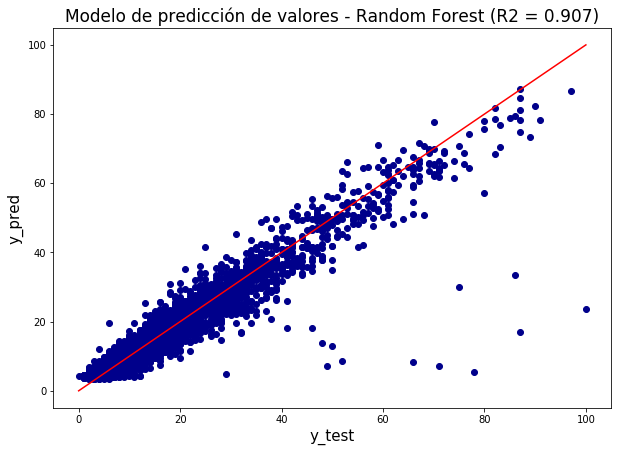

In [51]:
plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred_rr, c='darkblue')
plt.title("Modelo de predicción de valores - Random Forest (R2 = 0.907)",
          fontsize = 17)
rango_1 = max(max(y_pred_rr), max(y_test))
rango_2 = min(min(y_pred_rr), min(y_test))
plt.plot([rango_1, rango_2], [rango_1, rango_2], 'r-')
plt.xlabel('y_test', fontsize=15)
plt.ylabel('y_pred', fontsize=15)
plt.show()

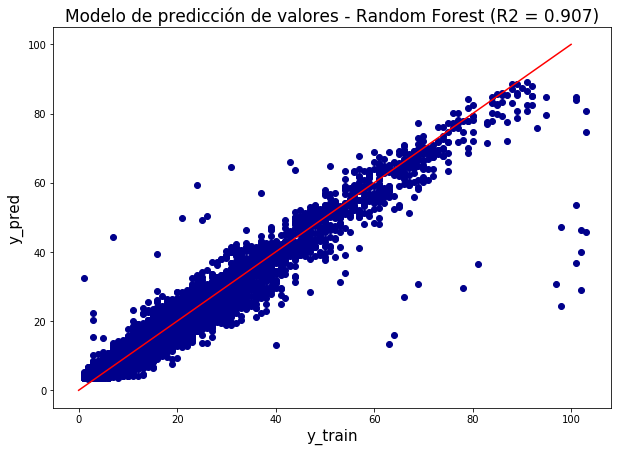

In [52]:
y_train_pred = regressor.predict(x_train)
plt.figure(figsize=(10,7))
plt.scatter(y_train, y_train_pred, c='darkblue')
plt.title("Modelo de predicción de valores - Random Forest (R2 = 0.907)",
          fontsize = 17)
rango_1 = max(max(y_train_pred), max(y_test))
rango_2 = min(min(y_train_pred), min(y_test))
plt.plot([rango_1, rango_2], [rango_1, rango_2], 'r-')
plt.xlabel('y_train', fontsize=15)
plt.ylabel('y_pred', fontsize=15)
plt.show()

In [53]:
df_final_test.to_csv('df_final_test.csv',index=False)

Finalmente, se procede a almacenar el mejor modelo ajustado, en este caso un modelo basado en Random Forest.

In [54]:
import os
import joblib

In [55]:
joblib.dump(regressor, "./random_forest_EV.joblib")

['./random_forest_EV.joblib']